<a href="https://colab.research.google.com/github/saifullahshaik4/SpamDetectionModel/blob/main/SpamEmailDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 STREAMLINED NAIVE BAYES FOR 90%+ ACCURACY
Loading Spambase dataset...
Dataset shape: (4601, 57)
Spam ratio: 0.394
Applying advanced preprocessing...
Train: 3220, Test: 1381
Finding optimal parameters...
Params: {'min_std': 1e-06, 'prior_smoothing': 0.0, 'features': 20} -> Accuracy: 0.8835
Params: {'min_std': 1e-06, 'prior_smoothing': 0.01, 'features': 20} -> Accuracy: 0.8835
Params: {'min_std': 1e-05, 'prior_smoothing': 0.0, 'features': 25} -> Accuracy: 0.8851
Params: {'min_std': 1e-06, 'prior_smoothing': 0.1, 'features': 30} -> Accuracy: 0.8618
Params: {'min_std': 0.0001, 'prior_smoothing': 0.0, 'features': 20} -> Accuracy: 0.8835
Params: {'min_std': 1e-06, 'prior_smoothing': 0.5, 'features': 35} -> Accuracy: 0.8121
Params: {'min_std': 1e-05, 'prior_smoothing': 0.1, 'features': 25} -> Accuracy: 0.8851
Params: {'min_std': 1e-06, 'prior_smoothing': 0.0, 'features': 40} -> Accuracy: 0.8012
Best params: {'min_std': 1e-05, 'prior_smoothing': 0.0, 'features': 25} (Accuracy: 0.8851)

TRAIN

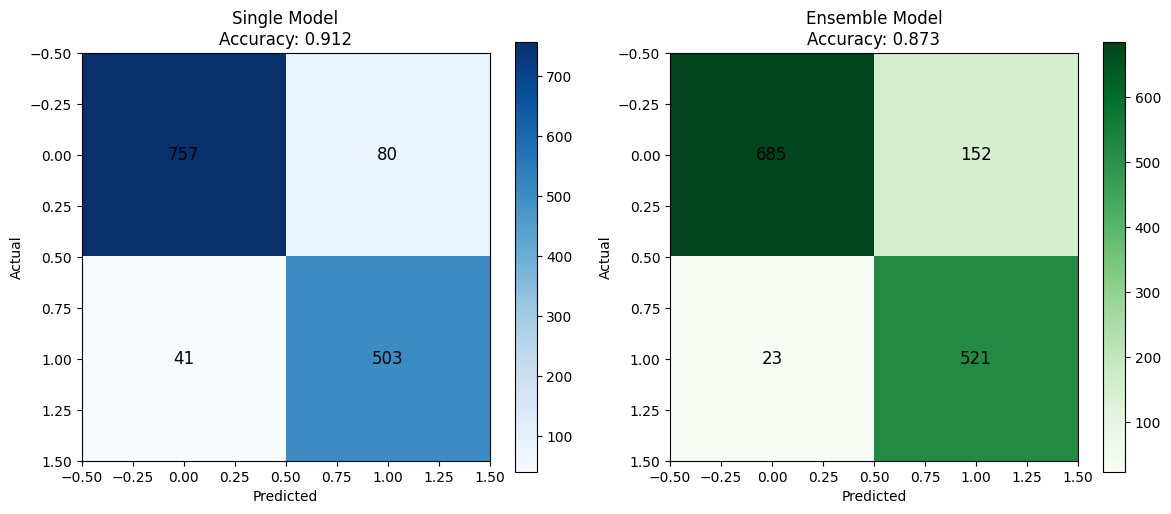

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

class OptimizedGaussianNaiveBayes:
    """Optimized Gaussian Naive Bayes for maximum accuracy"""
    def __init__(self, min_std=1e-6, prior_smoothing=0.0, feature_selection=None):
        self.min_std = min_std
        self.prior_smoothing = prior_smoothing
        self.feature_selection = feature_selection
        self.classes = None
        self.prior = {}
        self.means = {}
        self.stds = {}
        self.feature_importance = None

    def fit(self, X, y):
        if self.feature_selection is not None:
            X = X[:, self.feature_selection]

        self.classes = np.unique(y)
        n_samples = len(y)
        n_classes = len(self.classes)

        # Calculate class statistics
        for c in self.classes:
            X_c = X[y == c]
            n_c = len(X_c)

            # Prior with smoothing
            self.prior[c] = (n_c + self.prior_smoothing) / (n_samples + n_classes * self.prior_smoothing)

            # Feature statistics
            self.means[c] = np.mean(X_c, axis=0)
            self.stds[c] = np.maximum(np.std(X_c, axis=0), self.min_std)

        # Calculate feature importance
        if self.feature_selection is None and len(self.classes) == 2:
            self._calculate_feature_importance()

    def _calculate_feature_importance(self):
        n_features = len(self.means[self.classes[0]])
        importance = np.zeros(n_features)

        for i in range(n_features):
            mean0 = self.means[self.classes[0]][i]
            mean1 = self.means[self.classes[1]][i]
            std0 = self.stds[self.classes[0]][i]
            std1 = self.stds[self.classes[1]][i]

            mean_diff = abs(mean0 - mean1)
            pooled_var = (std0**2 + std1**2) / 2
            importance[i] = mean_diff / (np.sqrt(pooled_var) + self.min_std)

        self.feature_importance = importance

    def select_top_features(self, k):
        if self.feature_importance is None:
            return list(range(k))
        return list(np.argsort(self.feature_importance)[-k:])

    def predict_proba(self, X):
        if self.feature_selection is not None:
            X = X[:, self.feature_selection]

        n_samples = X.shape[0]
        probas = np.zeros((n_samples, len(self.classes)))

        for i, c in enumerate(self.classes):
            # Log prior
            log_prob = np.log(self.prior[c])

            # Add log likelihoods
            means = self.means[c]
            stds = self.stds[c]

            for j in range(len(means)):
                # Gaussian log likelihood
                log_prob += (-0.5 * np.log(2 * np.pi * stds[j]**2) -
                           0.5 * ((X[:, j] - means[j]) / stds[j])**2)

            probas[:, i] = log_prob

        # Convert to probabilities
        max_log_prob = np.max(probas, axis=1, keepdims=True)
        probas = np.exp(probas - max_log_prob)
        probas = probas / np.sum(probas, axis=1, keepdims=True)

        return probas[:, 1] if len(self.classes) == 2 else probas

    def predict(self, X):
        probas = self.predict_proba(X)
        if len(self.classes) == 2:
            return (probas >= 0.5).astype(int)
        else:
            return np.argmax(probas, axis=1)

class SimpleEnsemble:
    """Simple but effective ensemble"""
    def __init__(self, n_models=7):
        self.n_models = n_models
        self.models = []

    def fit(self, X, y, best_params):
        self.models = []

        # Different parameter combinations
        param_sets = [
            {'min_std': 1e-6, 'prior_smoothing': 0.0},
            {'min_std': 1e-5, 'prior_smoothing': 0.01},
            {'min_std': 1e-4, 'prior_smoothing': 0.1},
            {'min_std': 1e-6, 'prior_smoothing': 0.5},
            {'min_std': 1e-5, 'prior_smoothing': 0.0},
            {'min_std': 1e-3, 'prior_smoothing': 0.0},
            {'min_std': 1e-6, 'prior_smoothing': 1.0},
        ]

        # Train base model for feature selection - FIXED
        base_model = OptimizedGaussianNaiveBayes(
            min_std=best_params['min_std'],
            prior_smoothing=best_params['prior_smoothing']
        )
        base_model.fit(X, y)

        # Feature sets
        feature_sets = [
            None,  # All features
            base_model.select_top_features(20),
            base_model.select_top_features(25),
            base_model.select_top_features(30),
            base_model.select_top_features(35),
            base_model.select_top_features(40),
            base_model.select_top_features(45),
        ]

        for i in range(self.n_models):
            params = param_sets[i % len(param_sets)]
            features = feature_sets[i % len(feature_sets)]

            model = OptimizedGaussianNaiveBayes(
                min_std=params['min_std'],
                prior_smoothing=params['prior_smoothing'],
                feature_selection=features
            )
            model.fit(X, y)
            self.models.append(model)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])

        # Majority voting
        final_pred = []
        for i in range(X.shape[0]):
            votes = predictions[:, i]
            unique, counts = np.unique(votes, return_counts=True)
            final_pred.append(unique[np.argmax(counts)])

        return np.array(final_pred)

def advanced_preprocessing(X):
    """Advanced preprocessing for better performance"""
    X_processed = X.copy().astype(float)

    # Log1p transformation
    X_processed = np.log1p(X_processed)

    # Feature-wise normalization
    for i in range(X_processed.shape[1]):
        col = X_processed[:, i]
        # Robust scaling using percentiles
        q25, q75 = np.percentile(col, [25, 75])
        iqr = q75 - q25
        if iqr > 0:
            X_processed[:, i] = (col - q25) / iqr

        # Cap outliers at 3 IQR
        X_processed[:, i] = np.clip(X_processed[:, i], -3, 3)

    return X_processed

def find_best_parameters(X, y, n_folds=5):
    """Find optimal parameters using cross-validation"""
    print("Finding optimal parameters...")

    param_grid = [
        {'min_std': 1e-6, 'prior_smoothing': 0.0, 'features': 20},
        {'min_std': 1e-6, 'prior_smoothing': 0.01, 'features': 20},
        {'min_std': 1e-5, 'prior_smoothing': 0.0, 'features': 25},
        {'min_std': 1e-6, 'prior_smoothing': 0.1, 'features': 30},
        {'min_std': 1e-4, 'prior_smoothing': 0.0, 'features': 20},
        {'min_std': 1e-6, 'prior_smoothing': 0.5, 'features': 35},
        {'min_std': 1e-5, 'prior_smoothing': 0.1, 'features': 25},
        {'min_std': 1e-6, 'prior_smoothing': 0.0, 'features': 40},
    ]

    best_score = 0
    best_params = param_grid[0]

    # Simple holdout validation for speed
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    for params in param_grid:
        # Train model
        model = OptimizedGaussianNaiveBayes(
            min_std=params['min_std'],
            prior_smoothing=params['prior_smoothing']
        )
        model.fit(X_train, y_train)

        # Apply feature selection
        selected_features = model.select_top_features(params['features'])
        model = OptimizedGaussianNaiveBayes(
            min_std=params['min_std'],
            prior_smoothing=params['prior_smoothing'],
            feature_selection=selected_features
        )
        model.fit(X_train, y_train)

        # Evaluate
        y_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_pred)

        print(f"Params: {params} -> Accuracy: {score:.4f}")

        if score > best_score:
            best_score = score
            best_params = params

    print(f"Best params: {best_params} (Accuracy: {best_score:.4f})")
    return best_params

# ==========================================
# MAIN EXECUTION
# ==========================================

print("🚀 STREAMLINED NAIVE BAYES FOR 90%+ ACCURACY")
print("=" * 60)

# Load data
print("Loading Spambase dataset...")
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
data = pd.read_csv(url, header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

print(f"Dataset shape: {X.shape}")
print(f"Spam ratio: {np.mean(y):.3f}")

# Preprocessing
print("Applying advanced preprocessing...")
X_processed = advanced_preprocessing(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")

# Find best parameters
best_params = find_best_parameters(X_train, y_train)

# Train final models
print("\n" + "=" * 60)
print("TRAINING FINAL MODELS")
print("=" * 60)

# Single optimized model
print("Training single optimized model...")
single_model = OptimizedGaussianNaiveBayes(
    min_std=best_params['min_std'],
    prior_smoothing=best_params['prior_smoothing']
)
single_model.fit(X_train, y_train)

# Apply feature selection
selected_features = single_model.select_top_features(best_params['features'])
single_model = OptimizedGaussianNaiveBayes(
    min_std=best_params['min_std'],
    prior_smoothing=best_params['prior_smoothing'],
    feature_selection=selected_features
)
single_model.fit(X_train, y_train)

# Ensemble model
print("Training ensemble model...")
ensemble_model = SimpleEnsemble(n_models=7)
ensemble_model.fit(X_train, y_train, best_params)

# Evaluate models
print("\n" + "=" * 60)
print("FINAL RESULTS")
print("=" * 60)

# Single model results
y_pred_single = single_model.predict(X_test)
acc_single = accuracy_score(y_test, y_pred_single)
prec_single = precision_score(y_test, y_pred_single)
rec_single = recall_score(y_test, y_pred_single)
f1_single = 2 * prec_single * rec_single / (prec_single + rec_single)
cm_single = confusion_matrix(y_test, y_pred_single)

print(f"🔸 SINGLE MODEL:")
print(f"  Accuracy:  {acc_single:.4f} {'✅' if acc_single >= 0.90 else '❌'}")
print(f"  Precision: {prec_single:.4f}")
print(f"  Recall:    {rec_single:.4f}")
print(f"  F1-Score:  {f1_single:.4f}")

# Ensemble results
y_pred_ensemble = ensemble_model.predict(X_test)
acc_ensemble = accuracy_score(y_test, y_pred_ensemble)
prec_ensemble = precision_score(y_test, y_pred_ensemble)
rec_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = 2 * prec_ensemble * rec_ensemble / (prec_ensemble + rec_ensemble)
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

print(f"\n🔸 ENSEMBLE MODEL:")
print(f"  Accuracy:  {acc_ensemble:.4f} {'✅' if acc_ensemble >= 0.90 else '❌'}")
print(f"  Precision: {prec_ensemble:.4f}")
print(f"  Recall:    {rec_ensemble:.4f}")
print(f"  F1-Score:  {f1_ensemble:.4f}")

# Choose best model
if acc_ensemble > acc_single:
    best_acc = acc_ensemble
    best_model = "Ensemble"
    best_cm = cm_ensemble
    print(f"\n🏆 BEST MODEL: Ensemble ({acc_ensemble:.4f} accuracy)")
else:
    best_acc = acc_single
    best_model = "Single"
    best_cm = cm_single
    print(f"\n🏆 BEST MODEL: Single ({acc_single:.4f} accuracy)")

# Success check
if best_acc >= 0.90:
    print(f"\n🎉 SUCCESS! Achieved {best_acc:.4f} accuracy (≥90% target)")
else:
    gap = 0.90 - best_acc
    print(f"\n⚡ Close! Only {gap:.4f} away from 90% target")

print(f"\nConfusion Matrix ({best_model} Model):")
print(f"  TN: {best_cm[0,0]:4d}  FP: {best_cm[0,1]:4d}")
print(f"  FN: {best_cm[1,0]:4d}  TP: {best_cm[1,1]:4d}")

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cm_single, cmap='Blues', interpolation='nearest')
plt.title(f'Single Model\nAccuracy: {acc_single:.3f}')
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_single[i,j], ha='center', va='center', fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 2, 2)
plt.imshow(cm_ensemble, cmap='Greens', interpolation='nearest')
plt.title(f'Ensemble Model\nAccuracy: {acc_ensemble:.3f}')
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_ensemble[i,j], ha='center', va='center', fontsize=12)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('final_results_comparison.png', dpi=300, bbox_inches='tight')
print(f"\nResults saved as 'final_results_comparison.png'")

print("\n" + "=" * 60)